In [1]:
import tensorflow as tf
import numpy as np

In [23]:
indices = tf.constant([[[0, 1], [0, 0], [0, 2], [0, 3]], 
                      [[1, 0], [1, 1], [1, 2], [1, 3]]])
updates = tf.constant([[5, 6, 7, 8],
                        [1, 2, 3, 4]])
shape = tf.constant([2, 4])
scatter1 = tf.scatter_nd(indices, updates, shape)
with tf.Session() as sess:
    print(sess.run(scatter1))

[[6 5 7 8]
 [1 2 3 4]]


In [20]:
t = np.array([[0], [2]], dtype=np.int32)
indices = tf.constant(t)
print (t.shape)

t = np.array([[[5, 5, 5, 5], [6, 6, 6, 6],
                        [7, 7, 7, 7], [8, 8, 8, 8]],
                       [[5, 5, 5, 5], [6, 6, 6, 6],
                        [7, 7, 7, 7], [8, 8, 8, 8]]])
updates = tf.constant(t)
print (t.shape)

shape = tf.constant([4, 4, 4])
scatter = tf.scatter_nd(indices, updates, shape)
with tf.Session() as sess:
    a = sess.run(scatter)
    print (a.shape)

(2, 1)
(2, 4, 4)
(4, 4, 4)


In [11]:
indices.shape

TensorShape([Dimension(2), Dimension(1)])

In [28]:
import cv2
import os

In [34]:
import matplotlib
from matplotlib import pyplot as pl
%matplotlib inline

def crop_and_resize (frame):
    return cv2.resize(frame[36:250, 114:328, :], (15, 15), interpolation = cv2.INTER_LINEAR)


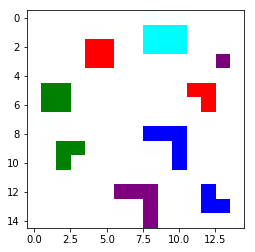

In [35]:
cap = cv2.VideoCapture(os.path.join('..', 'target', '0', '0.mp4'))
ret, frame = cap.read()

img = crop_and_resize(frame)

pl.imshow(img)

In [36]:
img.shape

(15, 15, 3)

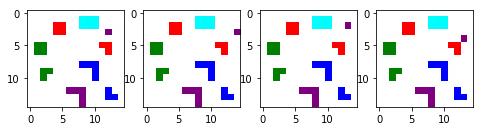

In [53]:
def create_indices ( shape, pos, action ):
    # Because we will only shift cell in the first 2 dimensions
    indices = np.zeros((shape, shape, 2), dtype=np.int32)
    
    for i in range(shape):
        for j in range(shape):
            indices[i,j]= [i,j]
    
    i = pos[0]
    j = pos[1]
    
    if action == 'left':
        indices[i,j] = [i,j-1]
        indices[i,j-1] = [i,j]
        
    if action == 'right':
        indices[i,j] = [i,j+1]
        indices[i,j+1] = [i,j]
        
    if action == 'up':
        indices[i,j] = [i-1,j]
        indices[i-1,j] = [i,j]
        
    if action == 'down':
        indices[i,j] = [i+1,j]
        indices[i+1,j] = [i,j]
        
    return tf.constant(indices)

updates = tf.constant(img)
shape = tf.constant([15, 15, 3])

fig=pl.figure(figsize=(8, 8))

with tf.Session() as sess:
    for i,action in enumerate(['left', 'right', 'up', 'down']):
        indices = create_indices(15, [3,13], action)
        scatter = tf.scatter_nd(indices, updates, shape)
        new_img = sess.run(scatter)
    
        fig.add_subplot(1, 4, i + 1)
        pl.imshow(new_img)
        
pl.show()